In [36]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [37]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [38]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [39]:
df = pd.read_csv('../data/stud.csv')

#### Show Top 5 Records

In [40]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [41]:
X = df.drop(columns=['math_score'],axis=1)

In [42]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [43]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [44]:
y = df['math_score']

In [45]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [46]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [47]:
X = preprocessor.fit_transform(X)

In [48]:
X.shape

(1000, 19)

In [49]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [50]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [51]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for model_name, model in models.items():
    try:
        # Check the model name and types
        print(f"Training model: {model_name}")
        print(f"y_train type: {type(y_train)}, y_train: {y_train}")  # Debugging
        
        model.fit(X_train, y_train)  # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Evaluate Train and Test dataset
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        print(f"{model_name}")
        model_list.append(model_name)

        print("Model performance for Training set")
        print(f"- Root Mean Squared Error: {model_train_rmse:.4f}")
        print(f"- Mean Absolute Error: {model_train_mae:.4f}")
        print(f"- R2 Score: {model_train_r2:.4f}")

        print('----------------------------------')

        print("Model performance for Test set")
        print(f"- Root Mean Squared Error: {model_test_rmse:.4f}")
        print(f"- Mean Absolute Error: {model_test_mae:.4f}")
        print(f"- R2 Score: {model_test_r2:.4f}")
        
        r2_list.append(model_test_r2)

        print('=' * 35)
        print('\n')
    except Exception as e:
        print(f"Error training {model_name}: {e}")

Training model: Linear Regression
y_train type: <class 'pandas.core.series.Series'>, y_train: 29     62
535    66
695    79
557    61
836    73
       ..
106    87
270    69
860    53
435    50
102    85
Name: math_score, Length: 800, dtype: int64
Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Training model: Lasso
y_train type: <class 'pandas.core.series.Series'>, y_train: 29     62
535    66
695    79
557    61
836    73
       ..
106    87
270    69
860    53
435    50
102    85
Name: math_score, Length: 800, dtype: int64
Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mea

### Results

In [52]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
6,CatBoosting Regressor,0.851632
4,Random Forest Regressor,0.851195
7,AdaBoost Regressor,0.848556
5,XGBRegressor,0.827797
1,Lasso,0.825320
3,Decision Tree,0.723533


## Linear Regression

In [53]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


## Plot y_pred and y_test

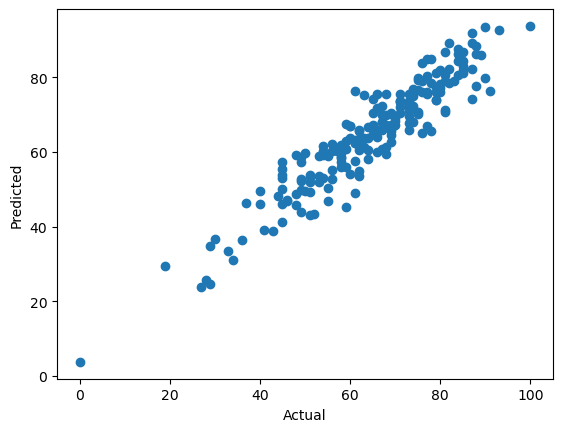

In [54]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

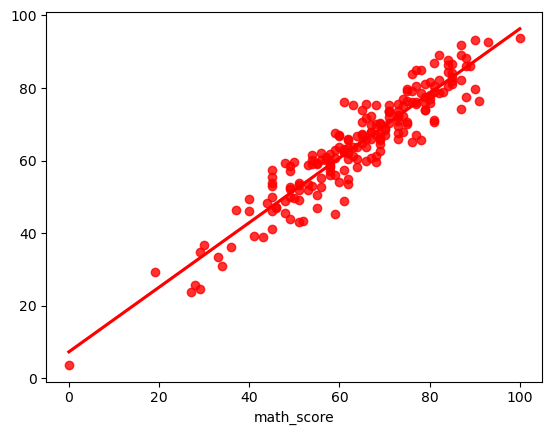

In [55]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [56]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
